# Comparison of Machine Learning Models on MNIST Dataset

Q Yun (Dec 2024)

The MNIST (Modified National Institute of Standards and Technology) dataset, with 70,000 grayscale images of handwritten 0-9 digits,  has been widely used for benchmarking different image recognition algorithms. Although convolutional neural network (CNN) and its variants are now widely considered the most effective models for image recognition, traditional machine learning algorithms tend to be more interpretable and may work well when the amount of data is limited. Therefore the advantages and disadvantages of both traditional machine learning algorithms and neural networks are worth exploring. This project will:

- Implement KNN (K-nearest neighbours), SVM (support vector machine), decision tree and random forest, ANN (artificial neural network) and CNN (including its variant of ResNet50) on MNIST dataset, and find the most appropriate model;
- Investigate the impact of dimension reduction on the performance of  some models.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


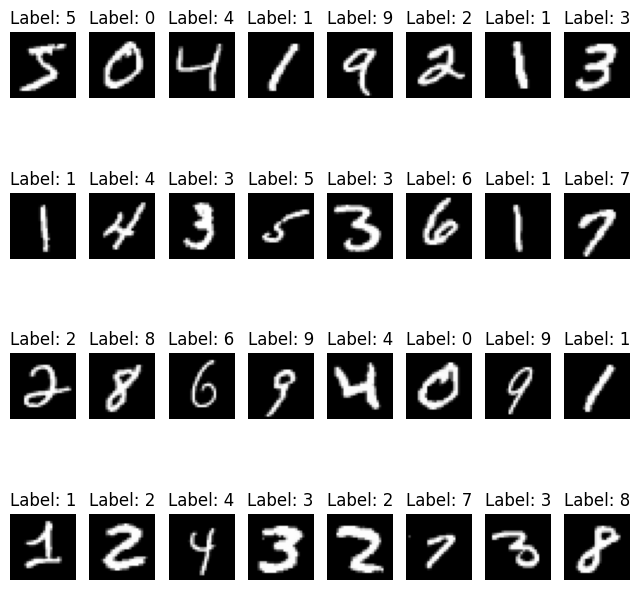

In [ ]:
# using tensorflow to import the dataset
from tensorflow import keras
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Reshape and combine the data
X = x_train.reshape(60000, 784).astype('float32')
X = np.concatenate((X, x_test.reshape(10000, 784).astype('float32')))
y = np.concatenate((y_train, y_test))

# Last 10,000 samples as test set
X_test = X[-10000:]
y_test = y[-10000:]

# Remaining 60,000 samples for training/validation
X_train_full = X[:-10000]
y_train_full = y[:-10000]

# plot the first 32 samples
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(X_train_full[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_train_full[i]}')
    plt.axis('off')
plt.show()


# Methodology


## Data preprocessing
The dataset is split into a training set (the first 60,000 samples) and a test set (the last 10,000 samples) to ensure the comparability for other similar experiments. The training set may be further split into a train subset and a validation subset for some algorithms. A good practice is to check if all targeted classes are present in the training set and if the distribution of different classes are skewed (Gopalakrishnan, 2022). It can be seen though that the dataset are not skewed towards any particular digits (see Figure 1).


In [ ]:
# monitor the execute time of each block
!pip install ipython-autotime
%load_ext autotime

# Further exploration of the dataset
## check the shape
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of X_train_full:", X_train_full.shape)
print("Shape of y_train_full:", y_train_full.shape)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.5 MB/s eta 0:00:00
Shape of X_test: (10000, 784)
Shape of y_test: (10000,)
Shape of X_train_full: (60000, 784)
Shape of y_train_full: (60000,)
time: 6.6 ms (started: 2025-01-27 23:50:39 +00:00)


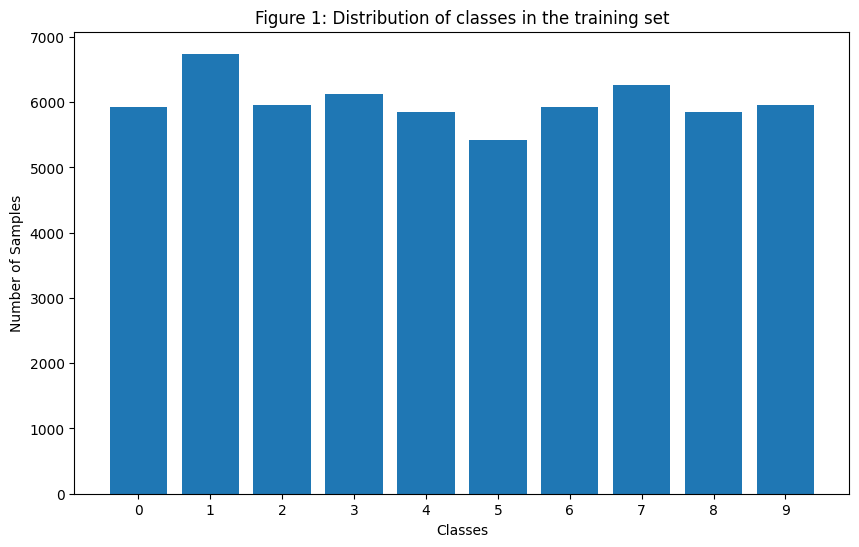

time: 312 ms (started: 2025-01-27 23:51:45 +00:00)


In [ ]:
# produce a histogram of different classes in the training set

import matplotlib.pyplot as plt

# Count the occurrences of each class
unique_classes, class_counts = np.unique(y_train_full, return_counts=True)

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts)
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Figure 1: Distribution of classes in the training set")
plt.xticks(unique_classes)  # Ensure all class labels are displayed
plt.show()

It is often beneficial to scale the features(the 784 columns representing the pixels) to ensure that none of them have oversized impact on the models, and also to improve the convergence of gradient descend based algorithms. Two common feature scaling methods, standardisation (which centres the data at the mean of 0 and then rescale by the standard deviation of 1) and normalisation (which rescales the features within a range of 0 to 1) becomes the options. Since all pixel values fall within the range of 0 to 255 and the distributions of features are not necessarily Gaussian, the dataset will be normalised.

In [ ]:
# normalise the train and test data
X_train_scaled, X_test_scaled = X_train_full / 255.0, X_test / 255.0
# check the data shape
print("Shape of X_test_scaled:", X_test_scaled.shape)
print("Shape of X_train_scaled:", X_train_scaled.shape)

# check the type
type(X_train_full)

Shape of X_test_scaled: (10000, 784)
Shape of X_train_scaled: (60000, 784)


numpy.ndarray

time: 134 ms (started: 2025-01-27 23:52:16 +00:00)


## Models implemented
Although logistic regression can be extended to handle multiclass classification problems, it can be a bit clumsy to implement, while Linear discriminant analysis (LDA) assumes the data is normally distributed with the covariance matrix for all classes, which may not be the case. Therefore KNN, SVM, decision tree and random forest as the traditional machine learning algorithms will be implemented. For the deep learning models, a simple artificial neural network can serve as a benchmark to assess the performance of CNN (including ResNet50).

Dimension reduction may enhance both computational efficiency and model performance. Among all the reduction techniques, PCA (principal component analysis) is usually limited in handling non-linear data. T-sne (t-Distributed Stochastic Neighbour Embedding) clusters well on the MNIST dataset (see Naidu, 2021). However, after an initial effort to implement it, it was found that t-sne can’t be implemented consistently to the test data, and the transformation also proved to be computationally expensive, therefore it was excluded in this project. UMAP (Uniform Manifold Approximation and Projection) also handles non-linear data well, so will be implemented to assess its impact on some traditional machine learning models. Neural networks are already good at feature extraction, therefore they usually require no dimension reduction.

## Metrics for model evaluation
While mean squared error is a good metric for regression tasks, accuracy, precision, recall and F1-score are more appropriate for classifications. Precision or recall may be more appropriate when the cost of false positive or false negative is high, but this is not a concern in identifying the digits in this project. Although accuracy can be misleading for imbalanced dataset, this is not the case for the MNIST dataset (as shown in the previous figure), therefore accuracy becomes a natural choice of the metric. Confusion matrices may help us identify the areas for improvement, hence will also be included to assist our analysis.

# Results and analysis
**KNN model.** KNN, based on the proximity of data points, is easy to implement. However it can be computationally expensive and sensitive to the number of neighbours (k) chosen. A cross-validation method (with 5 folds) was implemented on the training set, and it turned out k=3 is the best value. When the KNN model (with k=3) was applied on the test set, it resulted in a surprisingly good test accuracy of 97.05%.



In [ ]:
# TIME CONSUMING: cross validation to find the best k value for KNN model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Define a range of k values to test
k_values = list(range(1, 10))
cv_scores = []

# Loop through the k values and perform cross-validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train_full, cv=5, scoring='accuracy')  # Example: 5-fold cross-validation
    cv_scores.append(scores.mean())

# Find the k value with the highest cross-validation score
optimal_k = k_values[cv_scores.index(max(cv_scores))]

print(f"Optimal k: {optimal_k}")


Optimal k: 3


In [ ]:
# define a function to fit the KNN model with the best value of K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
def knn_fit_predict(X_train, y_train, X_test, y_test, k=3):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  return knn, accuracy
knn, knn_accuracy = knn_fit_predict(X_train_scaled, y_train_full, X_test_scaled, y_test)
print(f"KNN Accuracy: {knn_accuracy}")


KNN Accuracy: 0.9705
time: 31.8 s (started: 2025-01-27 23:52:52 +00:00)


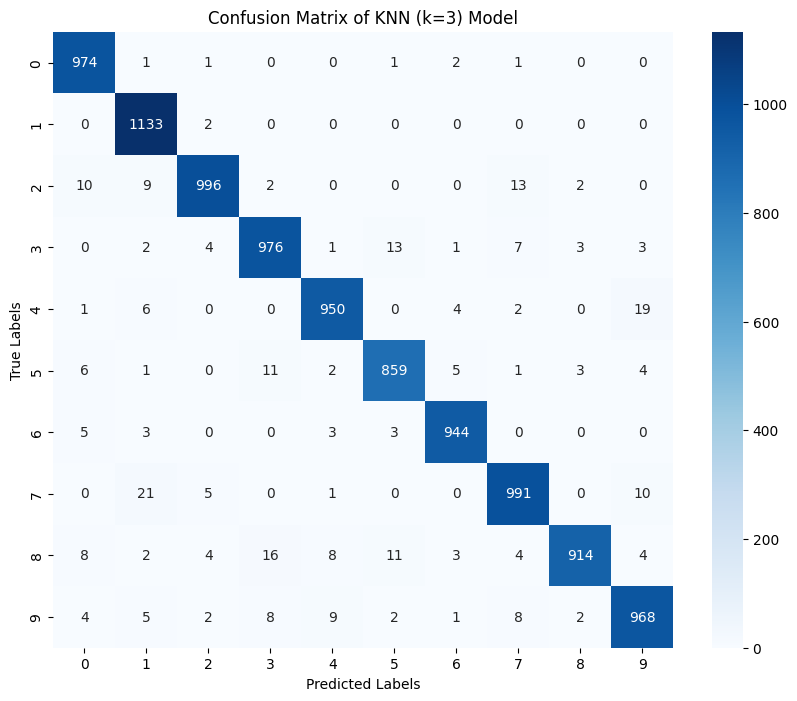

time: 28.1 s (started: 2025-01-27 23:53:38 +00:00)


In [ ]:
# generate confusion matrix by using the trained knn model

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = knn.predict(X_test_scaled)

knn_cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(knn_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of KNN (k=3) Model")
plt.show()

In [ ]:
# generate classification report of knn_cm

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

time: 15.7 ms (started: 2025-01-27 23:54:18 +00:00)


After defining a function to search the best k-value between 1 and 10 for the KNN models, for the dataset transformed with PCA (with 3 principal components), the highest test accuracy achieved in KNN was only 50.48% (when k=9). When the number of components in PCA increased to 10, the highest KNN (k=6) test accuracy rose to 92.91%. However, a UMAP (with 3 components) transformed data led to the highest KNN(k=10) accuracy of 95.57%, which indicated the superiority of UMAP over PCA on the MNIST dataset. Further increase of UMAP components to 10 only led to a slight accuracy rise to 95.67%. However since all these rates are lower than the previous 97.05% on the non-transformed data, dimension reduction appeared to be inappropriate for KNN model on the MINIST dataset.

In [ ]:
# define a function to apply knn with k values in the range of 1 to 11
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
def knn_fit_search(X_train, y_train, X_test, y_test):
    k_values = list(range(1, 11))
    accuracy_rate = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_rate.append((k, accuracy))
    return accuracy_rate

time: 839 µs (started: 2025-01-27 23:54:57 +00:00)


In [ ]:
# implement the PCA with 3 components to the train data
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

time: 721 ms (started: 2025-01-28 00:00:16 +00:00)


In [ ]:
# apply knn on PCA transformed data to find the higest accuracy rate
k3_rate = knn_fit_search(X_train_pca, y_train_full, X_test_pca, y_test)
highest_accuracy = max(k3_rate, key=lambda item: item[1])  # Use key=lambda to specify the accuracy (item[1]) for comparison

print(f"Highest accuracy: {highest_accuracy[1]} achieved with k = {highest_accuracy[0]}")

Highest accuracy: 0.5048 achieved with k = 9
time: 6.16 s (started: 2025-01-28 00:00:21 +00:00)


In [ ]:
# PCA with 10 components
from sklearn import decomposition
pca10 = decomposition.PCA(n_components=10)
pca10.fit(X_train_scaled)
X_train_pca10 = pca10.transform(X_train_scaled)
X_test_pca10 = pca10.transform(X_test_scaled)

time: 676 ms (started: 2025-01-28 00:00:57 +00:00)


In [ ]:
k10_rate = knn_fit_search(X_train_pca10, y_train_full, X_test_pca10, y_test)
highest_accuracy = max(k10_rate, key=lambda item: item[1])

print(f"Highest accuracy: {highest_accuracy[1]} achieved with k = {highest_accuracy[0]}")

Highest accuracy: 0.9291 achieved with k = 6
time: 20.2 s (started: 2025-01-28 00:01:02 +00:00)


In [ ]:
!pip install umap-learn
import umap

reducer = umap.UMAP(n_components=3, random_state=42)
X_train_umap = reducer.fit_transform(X_train_scaled)
X_test_umap = reducer.transform(X_test_scaled)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.2 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


time: 2min 22s (started: 2025-01-28 00:19:19 +00:00)


In [ ]:
# Apply knn_fit_predict function to UMAP (3 compoents) transformed data
umap_accuracy_rates = knn_fit_search(X_train_umap, y_train_full, X_test_umap, y_test)
highest_accuracy = max(umap_accuracy_rates, key=lambda item: item[1])
print(f"Highest accuracy: {highest_accuracy[1]} achieved with k = {highest_accuracy[0]}")

Highest accuracy: 0.9557 achieved with k = 10


In [ ]:
# Increase the component for UMAP to 10 and check the performance
reducer = umap.UMAP(n_components=10, random_state=42)
X_train_umap10 = reducer.fit_transform(X_train_scaled)
X_test_umap10 = reducer.transform(X_test_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# apply knn to the UMAP (10 components) transformed data
umap_accuracy_rates = knn_fit_search(X_train_umap10, y_train_full, X_test_umap10, y_test)
highest_accuracy = max(umap_accuracy_rates, key=lambda item: item[1])
print(f"Highest accuracy of KNN with UMAP of 10 components: {highest_accuracy[1]} achieved with k = {highest_accuracy[0]}")

Highest accuracy of KNN with UMAP of 10 components: 0.9567 achieved with k = 5


**Tree based models**. Decision trees, with a tree-like structure, are also easy to implement. However, a decision tree (without pruning) only achieved 87.98% test accuracy. A grid search cross-validation was carried out on the training set, it suggested that no pruning was needed (with a ccp-alpha value of 0) and entropy was better than gini as the criterion. When entropy criterion was adopted, the accuracy only increased slightly to 88.57%. Interestingly though, if a decision tree (no pruning) with a max depth of 10 is implemented on the UMAP (3 components) transformed data, the accuracy increased sharply to 95.04%, which indicated that decision trees may benefit from dimension reduction on the MNIST dataset

In [ ]:
#  Apply a decision tree model to the dataset

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the decision tree classifier
decision_tree = DecisionTreeClassifier()  # Create an instance of the class
decision_tree.fit(X_train_scaled, y_train_full)

# Make predictions on the test set
y_pred = decision_tree.predict(X_test_scaled)

# Evaluate the model
dt_accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {dt_accuracy}")

Decision Tree Accuracy: 0.8759
time: 19.7 s (started: 2025-01-28 00:02:16 +00:00)


In [ ]:
#TIME CONSUMING: grid search cross validation to find the hyperparameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Initialize the decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid for pruning
param_grid = {
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1], # Cost-complexity pruning
    'criterion' :['entropy','gini','log_loss']
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy') # 5-fold cross-validation
grid_search.fit(X_train_scaled, y_train_full)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0.0, 0.001, 0.01, 0.1],
                         'criterion': ['entropy', 'gini', 'log_loss']},
             scoring='accuracy')

time: 14min 25s (started: 2025-01-28 00:03:42 +00:00)


In [ ]:
print(f"Best parameters: {grid_search.best_params_}")
# Get the best estimator (decision tree with optimal hyperparameters)
best_decision_tree = grid_search.best_estimator_

Best parameters: {'ccp_alpha': 0.0, 'criterion': 'entropy'}
time: 1.44 ms (started: 2025-01-28 00:18:24 +00:00)


In [ ]:
# Make predictions on the test set using the best model
y_pred = best_decision_tree.predict(X_test_scaled)

# Evaluate the pruned decision tree model
dt_entropy_accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree (entropy) Accuracy: {dt_entropy_accuracy}")
print(f"Best parameters: {grid_search.best_params_}")

Decision Tree (entropy) Accuracy: 0.8857
Best parameters: {'ccp_alpha': 0.0, 'criterion': 'entropy'}
time: 10.6 ms (started: 2025-01-28 00:18:28 +00:00)


In [ ]:
# Initialize and train the decision tree classifier for the UMAP (3 components) transformed data
decision_tree = DecisionTreeClassifier(random_state=42, max_depth= 10,  criterion = 'entropy')
decision_tree.fit(X_train_umap, y_train_full)

# Make predictions on the test set
y_pred = decision_tree.predict(X_test_umap)

# Evaluate the model
dt_umap_accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy on the UMAP (3 components) transformed data: {dt_umap_accuracy}")

Decision Tree Accuracy on the UMAP (3 components) transformed data: 0.9524
time: 3.48 s (started: 2025-01-28 00:22:00 +00:00)


Ensemble methods, by combining the strength of multiple trees, usually perform better than a single tree. Random forest achieved an test accuracy of 96.85% (with a maximum depth of 15 and the entropy criterion). A XGBoost model resulted in a slightly different accuracy of 97.95%, indicating little difference between the two methods on the MNIST dataset.

In [ ]:
# random forest on the scaled data
from sklearn.ensemble import RandomForestClassifier

# Initialize and train a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, criterion='entropy')  # You can adjust hyperparameters as needed
rf_classifier.fit(X_train_scaled, y_train_full)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test_scaled)

# Evaluate the model (example using accuracy)
from sklearn.metrics import accuracy_score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of Random Forest on scaled data: {accuracy_rf}")

Accuracy of Random Forest on scaled data: 0.9685
time: 1min 17s (started: 2025-01-28 00:22:13 +00:00)


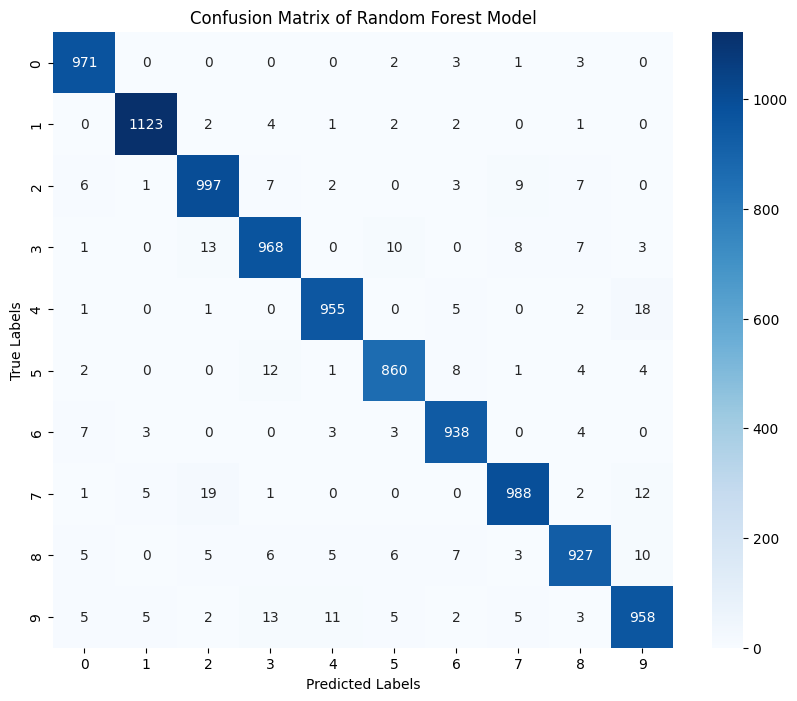

time: 756 ms (started: 2025-01-28 00:23:43 +00:00)


In [ ]:
# generate confusion matrix for random forest model

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions using the trained RandomForestClassifier
y_pred_rf = rf_classifier.predict(X_test_scaled)

# Generate the confusion matrix
rf_cm = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of Random Forest Model")
plt.show()

In [ ]:
# Generate the classification report for the random forest model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.97       958
           7       0.97      0.96      0.97      1028
           8       0.97      0.95      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

time: 25.6 ms (started: 2025-01-28 00:23:53 +00:00)


In [ ]:
# implement XGboost on the UMAP transformed training data
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=10, random_state=42) # Adjust parameters as needed

# Train the classifier
xgb_classifier.fit(X_train_scaled, y_train_full)

# Make predictions
y_pred_xgb = xgb_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy of XGBoost on the scaled data: {accuracy_xgb}")

Accuracy of XGBoost on the scaled data: 0.9795
time: 9min 21s (started: 2025-01-28 00:24:06 +00:00)


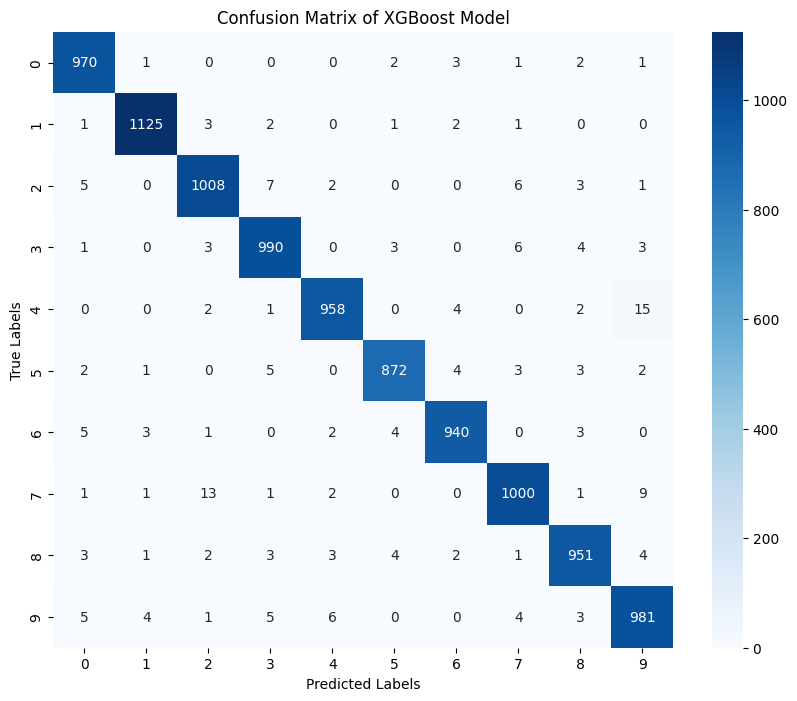

time: 906 ms (started: 2025-01-28 00:40:33 +00:00)


In [ ]:
# confusion matrix for the xgboost model

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions using the trained XGBoost classifier
y_pred_xgb = xgb_classifier.predict(X_test_scaled)

# Generate the confusion matrix
xgb_cm = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of XGBoost Model")
plt.show()

In [ ]:
# classification report for XGBoost model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

time: 13.8 ms (started: 2025-01-28 00:40:53 +00:00)


**Suppport vector machine (SVM)**. SVM handles non-linear data well with its Radial Basis Function (RBF) kernel. While a SVM model with the linear kernel achieved a test accuracy of 94.04%, an RBF kernel boosted the rate up to 97.92%. When the UMAP (3 components) transformed data was fed to SVM with RBF kernel, the test accuracy dipped slightly to 95.57%, while further increase of the UMAP components didn’t achieved any accuracy improvement. Therefore UMAP transformation may not help SVM with its accuracy. However, since training SVM can be slow, UMAP can significantly improve its computation efficiency with just slightly lower test accuracy if so is desired.

In [ ]:
# fit SVM on the scaled data
from sklearn.svm import SVC

# Initialize and train an SVC classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train_scaled, y_train_full)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test_scaled)

# Evaluate the model (example using accuracy)
svm_linear = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy of SVM (linear kernel) on scaled data: {svm_linear}")

Accuracy of SVM (linear kernel) on scaled data: 0.9404


In [ ]:
# fit SVM with RBF kernel on the scaled data
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42) # You can adjust hyperparameters like kernel and C
svm_classifier.fit(X_train_scaled, y_train_full)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test_scaled)

# Evaluate the model (example using accuracy)
svm_rbf = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy of SVM(with rbf) on scaled data: {svm_rbf}")

Accuracy of SVM(with rbf) on scaled data: 0.9792
time: 5min 51s (started: 2025-01-28 00:41:06 +00:00)


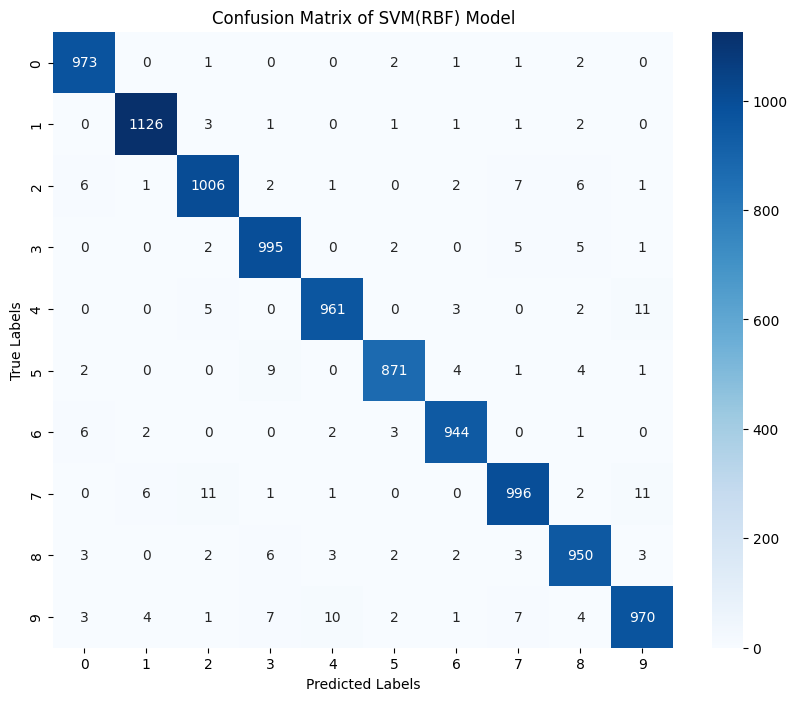

time: 1min 48s (started: 2025-01-28 00:50:59 +00:00)


In [ ]:
# confusion matrix of SVM (with rbf)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_svm = svm_classifier.predict(X_test_scaled)

svm_cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(10, 8))
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of SVM(RBF) Model")
plt.show()

In [ ]:
# generate classification report of svm_cm

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

time: 14.7 ms (started: 2025-01-28 00:53:21 +00:00)


In [ ]:
# Apply SVM to UMAP (3 components) transformed data
svm_classifier_umap = SVC(kernel='rbf', C=1.0, gamma='scale', random_state = 42) # Example with RBF kernel
svm_classifier_umap.fit(X_train_umap, y_train_full)
y_pred_svm_umap = svm_classifier_umap.predict(X_test_umap)
accuracy_svm_umap = accuracy_score(y_test, y_pred_svm_umap)
print(f"Accuracy of SVM(rbf) on UMAP data: {accuracy_svm_umap}")

Accuracy of SVM(rbf) on UMAP data: 0.9557


In [ ]:
# Apply SVM to UMAP (10 components) transformed data
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_classifier_umap10 = SVC(kernel='rbf', C=1.0, gamma='scale', random_state = 42) # Example with RBF kernel
svm_classifier_umap10.fit(X_train_umap10, y_train_full)
y_pred_svm_umap10 = svm_classifier_umap10.predict(X_test_umap10)
accuracy_svm_umap10 = accuracy_score(y_test, y_pred_svm_umap10)
print(f"Accuracy of SVM(rbf) on UMAP data: {accuracy_svm_umap10}")

Accuracy of SVM(rbf) on UMAP data: 0.9557


**Neural network**. Neural networks, by simulating the organisation of the human brain, are probably the best models in image recognition, but they require more training data and are usually computationally expensive. Overfitting can occur when the training dataset is small, but dropout as a regularisation technique can improve the robustness. Since our training dataset (60,000 images) is not very large, a simple neural network with a dropout rate of 0.2 was implemented to assess its performance on MNIST dataset.

Although it was not feasible in this project to fine tune all the hyperparameters, the number of epochs and learning rate may need tuning as they may have a significant impact on the performance. In order to find an appropriate epoch and also to monitor the effect of the chosen learning rate on the training convergence, the training set is further divided into a train subset (5,1000 samples) and a validation subset (9,000 samples), and the early stopping technique was carried out to prevent possible overfitting. The training was set to terminate when the validation loss stopped decreasing after 5 epochs, and the model would then be applied on the test set. A more conservative SGD (stochastic gradient descent) optimizer with a learning rate of 0.01 and a momentum of 0.9 was chosen. A potential downside of having a validation set is the reduced size of the training set. Although cross-validation could alleviate this problem, it was not implemented because several other experiments without using a validation set achieved a similar test accuracy (97.6% in Lin, 2017 and 96.2% in Rana et al, 2023). In the case of our simple 3-layer neural network (a linear layer, a ReLU layer followed by dropout, and another linear layer), the training loss converged well, indicating an appropriate learning rate, and the validation loss stopped decreasing after about 30 epochs and the early stopping was triggered (Figure 2). The model then achieved a test accuracy of 97.85%.



In [ ]:
#split the training set into a train and a validation set
from sklearn.model_selection import train_test_split
X_train_nn, X_val_nn, y_train, y_val = train_test_split(X_train_scaled, y_train_full, test_size=0.15, random_state=42)
#check the shape
print("Training set shape:", X_train_nn.shape, y_train.shape)
print("Validation set shape:", X_val_nn.shape, y_val.shape)

Training set shape: (51000, 784) (51000,)
Validation set shape: (9000, 784) (9000,)
time: 82.8 ms (started: 2025-01-28 00:53:50 +00:00)


In [ ]:
# a simple neural network with PyTorch on scaled data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_nn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.astype(int), dtype=torch.long) # Assuming y_train_full is your target variable
y_val_tensor = torch.tensor(y_val.astype(int), dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Adjust batch size as needed
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Hyperparameters
input_size = 784
hidden_size = 128
num_classes = 10
dropout_rate = 0.2
learning_rate = 0.01
num_epochs = 100 # Increase the number of epochs for better results

train_losses = []
val_losses = []
# Initialize the model, loss function, and optimizer
model = SimpleNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize with a very large value
patience = 5  # Number of epochs to wait before stopping
epochs_without_improvement = 0

# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    # train model
    model.train()
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate average
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if (epoch + 1) % 5 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}:]')
      print(f'Train Loss: {train_losses[-1]:.4f}')
      print(f'Validation Loss: {val_losses[-1]:.4f}\n')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break  # Exit the training loop

Epoch [5/100:]
Train Loss: 0.1508
Validation Loss: 0.1238

Epoch [10/100:]
Train Loss: 0.0946
Validation Loss: 0.0883

Epoch [15/100:]
Train Loss: 0.0710
Validation Loss: 0.0754

Epoch [20/100:]
Train Loss: 0.0586
Validation Loss: 0.0692

Epoch [25/100:]
Train Loss: 0.0477
Validation Loss: 0.0680

Epoch [30/100:]
Train Loss: 0.0407
Validation Loss: 0.0636

Epoch [35/100:]
Train Loss: 0.0356
Validation Loss: 0.0647

Early stopping at epoch 35
time: 1min 15s (started: 2025-01-28 00:53:53 +00:00)


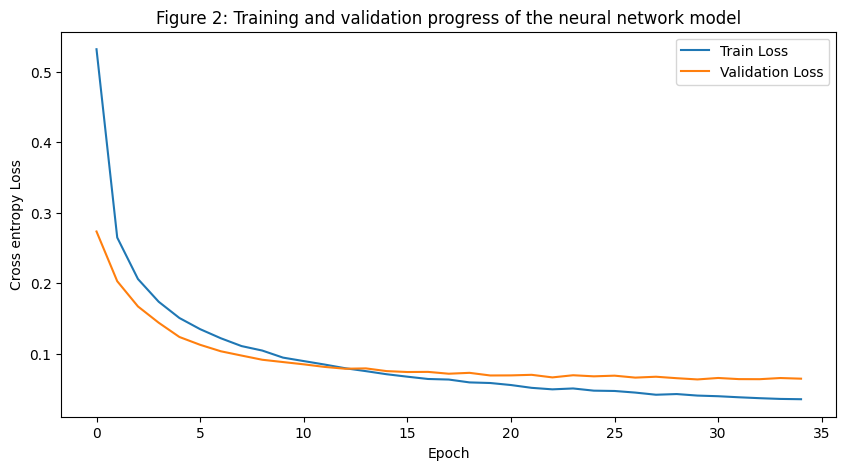

time: 277 ms (started: 2025-01-28 00:58:25 +00:00)


In [ ]:
# Plot traing process
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross entropy Loss')
plt.title('Figure 2: Training and validation progress of the neural network model')
plt.legend()
plt.show()

In [ ]:
# Testing the model

# Convert X_test_scaled and y_test to tensors
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.astype(int), dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    nn_accuracy = 100 * correct / total
    print(f'Test Accuracy: {nn_accuracy:.2f}%')

Test Accuracy: 97.85%
time: 200 ms (started: 2025-01-28 00:58:51 +00:00)


<ipython-input-36-1397bb340d49>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<ipython-input-37-b2028c30ae1d>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


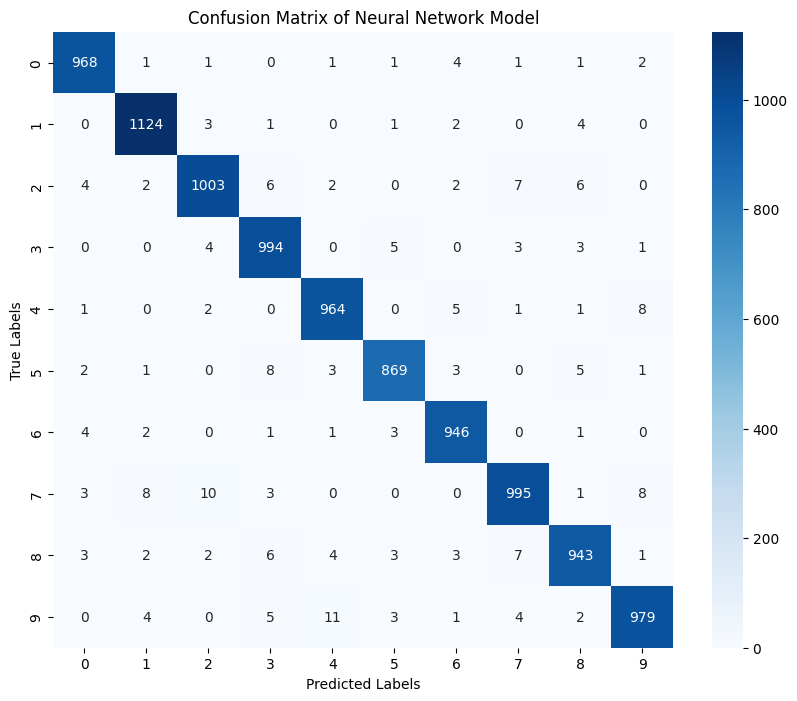

time: 756 ms (started: 2025-01-28 01:00:01 +00:00)


In [ ]:
# confusion matrix of the test data using the saved neural network model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    all_predictions = []
    all_labels = []
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

nn_cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(nn_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of Neural Network Model")
plt.show()

In [ ]:
# classification report of nn_cm

from sklearn.metrics import classification_report
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

time: 25.6 ms (started: 2025-01-28 01:00:10 +00:00)


**Convolutional Neural Network (CNN)**. As a specialised type of neural network, CNNs are widely accepted as a very powerful algorithm for image processing. They are composed of convolution layers, pooling layers and fully connected layers. Convolution layers, specifically designed to extract features from the images, play a crucial role in CNN’s strength, while the pooling layers help to reduce the dimensionality of parameters. In order to have a robust estimate of their performance, a 5-fold cross validation together with early stopping was carried out to find the test accuracy in each fold. Initial effort was made to include two 0.2 dropout in the convolution blocks, but this resulted in fluctuation in the training loss. Therefore, two convolution blocks, each consisting of a 2D convolution with a kernel size of 3, a ReLu followed with 0.1 dropout rate and a max pooling, were included in our designed CNN. It was also crucial to initialise the model within the iteration of each fold to avoid data leakage. Our training converged well (see appendix) and a mean test accuracy of 98.81% (standard deviation: 0.04%) was achieved.

In [ ]:
# implement CNN with 5 folds

# import the modules
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np


# Device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Reshape data for CNN input
X_train_reshaped = X_train_scaled.reshape(-1, 1, 28, 28)
X_test_resphaped = X_test_scaled.reshape(-1, 1, 28, 28)

Using device: cuda
time: 1.99 ms (started: 2025-01-28 01:00:23 +00:00)


In [ ]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(32 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Hyperparameters
num_epochs = 25
batch_size = 64
learning_rate = 0.01

time: 1.18 ms (started: 2025-01-28 01:00:29 +00:00)


In [ ]:
# define a function to train and validate the CNN model
def train_and_validate_cnn(model, X_train, y_train, X_val, y_val, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate):
    # Convert to tensors and create dataloaders
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.astype(int), dtype=torch.long).to(device)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val.astype(int), dtype=torch.long).to(device)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Define loss function and optimizer inside the function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    train_losses = []
    val_losses = []

    # Early stopping initialization
    best_val_loss = float('inf')  # Initialize with a very large value
    patience = 5  # Number of epochs to wait before stopping
    epochs_without_improvement = 0

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for images, labels in train_loader:
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader)) #take into account the number of batches

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        if (epoch + 1) % 5 == 0:  # Check if the current epoch is a multiple of 5
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Optionally save the best model here
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break  # Exit the training loop

    return model, train_losses, val_losses

time: 1.75 ms (started: 2025-01-28 01:00:34 +00:00)


In [ ]:
# apply k-fold of evaluation of CNN model on the train and validation data
def evaluate_cnn_kfold(X_train_scaled, y_train_full, X_test_scaled, y_test, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    test_results = []

     # Store losses for plotting
    all_train_losses = []
    all_val_losses = []

    for fold, (train_index, val_index) in enumerate(kfold.split(X_train_scaled)):
        print(f"Fold {fold+1}/{n_splits}")
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train_full[train_index], y_train_full[val_index]

        # Reshape data
        X_train_fold = X_train_fold.reshape(-1, 1, 28, 28)
        X_val_fold = X_val_fold.reshape(-1, 1, 28, 28)
        X_test_scaled = X_test_scaled.reshape(-1,1,28,28)

        # initialise th model
        model = CNN().to(device)

        # Train the CNN model
        model, train_losses, val_losses = train_and_validate_cnn(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold)

        # Store losses for this fold
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Evaluate on the test set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            # Evaluate on the test set
            X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
            y_test_tensor = torch.tensor(y_test.astype(int), dtype=torch.long).to(device)
            test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
            test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

            correct = 0
            total = 0
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            test_accuracy = 100 * correct / total
            print(f"Test Accuracy (Fold {fold + 1}): {test_accuracy:.2f}%")
            test_results.append(test_accuracy)

    # Plotting after all folds are complete
    plt.figure(figsize=(10, 6))
    for fold in range(n_splits):
        plt.plot(all_train_losses[fold], label=f"Train Loss (Fold {fold + 1})")
        plt.plot(all_val_losses[fold], label=f"Val Loss (Fold {fold + 1})")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("CNN 5-fold cross validation training and validation losses")
    #plt.ylim([0, 0.07])
    plt.legend(ncol=2)
    plt.show()

    return test_results

time: 2.29 ms (started: 2025-01-28 01:00:41 +00:00)


Fold 1/5
Epoch [5/25], Train Loss: 0.0607, Val Loss: 0.0514
Epoch [10/25], Train Loss: 0.0404, Val Loss: 0.0490
Epoch [15/25], Train Loss: 0.0298, Val Loss: 0.0453
Epoch [20/25], Train Loss: 0.0246, Val Loss: 0.0462
Early stopping at epoch 21
Test Accuracy (Fold 1): 98.86%
Fold 2/5
Epoch [5/25], Train Loss: 0.0614, Val Loss: 0.0575
Epoch [10/25], Train Loss: 0.0404, Val Loss: 0.0502
Epoch [15/25], Train Loss: 0.0292, Val Loss: 0.0492
Epoch [20/25], Train Loss: 0.0240, Val Loss: 0.0454
Early stopping at epoch 23
Test Accuracy (Fold 2): 98.80%
Fold 3/5
Epoch [5/25], Train Loss: 0.0602, Val Loss: 0.0650
Epoch [10/25], Train Loss: 0.0417, Val Loss: 0.0594
Epoch [15/25], Train Loss: 0.0314, Val Loss: 0.0537
Early stopping at epoch 18
Test Accuracy (Fold 3): 98.80%
Fold 4/5
Epoch [5/25], Train Loss: 0.0633, Val Loss: 0.0661
Epoch [10/25], Train Loss: 0.0446, Val Loss: 0.0497
Epoch [15/25], Train Loss: 0.0328, Val Loss: 0.0509
Early stopping at epoch 15
Test Accuracy (Fold 4): 98.75%
Fold 5/5

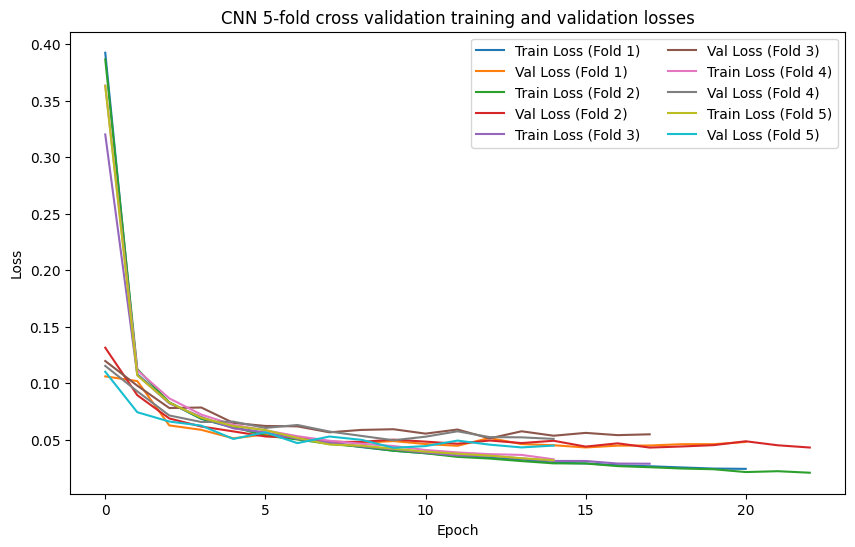

Overall Test Accuracies (5-fold): [98.86 98.8  98.8  98.75 98.86]
Mean Test Accuracy: 98.81%, Standard Deviation of Test Accuracies: 0.04%
time: 3min 26s (started: 2025-01-28 01:06:18 +00:00)


In [ ]:
# apply the k-fold to the training and test data
cnn_results = evaluate_cnn_kfold(X_train_scaled, y_train_full, X_test_scaled, y_test)

# print out the test accuracies and its mean and sd
cnn_results = np.array(cnn_results)
print(f"Overall Test Accuracies (5-fold): {cnn_results}")
print(f"Mean Test Accuracy: {np.mean(cnn_results):.2f}%, Standard Deviation of Test Accuracies: {np.std(cnn_results):.2f}%")

In [ ]:
# extract the mean accuracy for visualisation at a later stage
cnn_results = np.array(cnn_results)
cnn_mean_accuracy = round(np.mean(cnn_results), 2)

time: 811 µs (started: 2025-01-28 01:45:25 +00:00)


**ResNet**. ResNet is an improved type of CNN, with the inclusion of residual blocks using the skip connections to solve the vanishing (or exploding) gradient problems. ResNet50, a 50 layers ResNet architecture, was trained (with 10 epochs) and a test accuracy of 99.16%, the highest in our project, was reported. Tuning the hyperparameters may even further increase the accuracy.

In [ ]:
# implement Resnet50 on the train_dataset and test_dataset

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.reshape(-1, 1, 28, 28), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_full.astype(int), dtype=torch.long)
y_test_tensor = torch.tensor(y_test.astype(int), dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the first convolutional layer to accept grayscale images (1 channel instead of 3)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the fully connected layer to match the number of classes (10 digits)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)


# Define device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 15  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

resnet_accuracy = round(100 * correct / total, 2)
print(f"Test Accuracy: {resnet_accuracy}%")

Epoch [1/15], Loss: 0.1682
Epoch [2/15], Loss: 0.1093
Epoch [3/15], Loss: 0.1094
Epoch [4/15], Loss: 0.0492
Epoch [5/15], Loss: 0.0382
Epoch [6/15], Loss: 0.0379
Epoch [7/15], Loss: 0.0799
Epoch [8/15], Loss: 0.0450
Epoch [9/15], Loss: 0.0281
Epoch [10/15], Loss: 0.0384
Epoch [11/15], Loss: 0.0297
Epoch [12/15], Loss: 0.0377
Epoch [13/15], Loss: 0.0245
Epoch [14/15], Loss: 0.0227
Epoch [15/15], Loss: 0.0205
Test Accuracy: 99.16%
time: 11min 45s (started: 2025-01-28 01:20:33 +00:00)


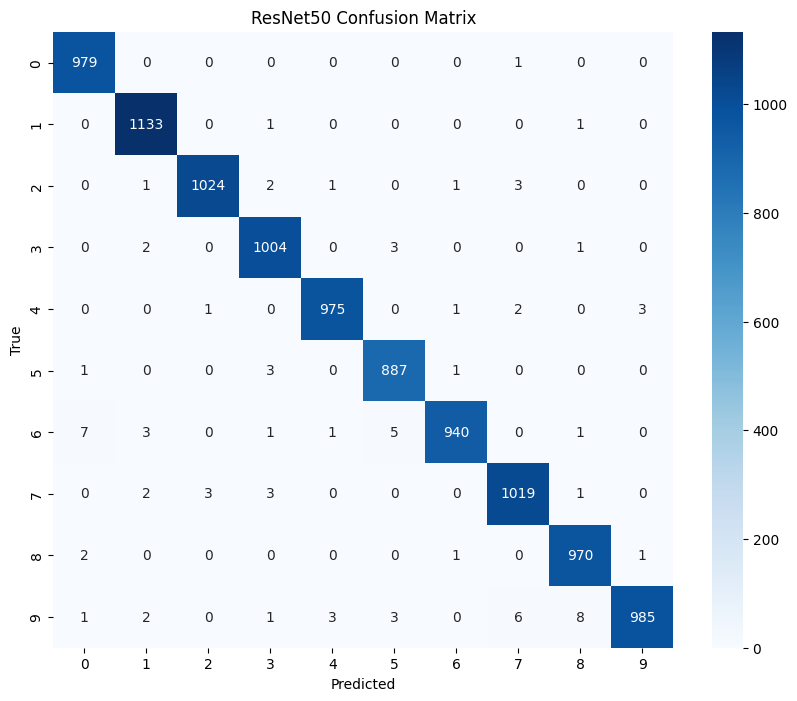

time: 2.43 s (started: 2025-01-28 01:34:47 +00:00)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Compute the confusion matrix
resnet_cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(resnet_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ResNet50 Confusion Matrix')
plt.show()

In [ ]:
# produce classificaton report of the resnet model
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

time: 23.7 ms (started: 2025-01-28 01:35:10 +00:00)


In [ ]:
test_accuracies = [knn_accuracy*100, dt_accuracy*100, round(accuracy_rf*100, 2), accuracy_xgb*100, svm_rbf*100, nn_accuracy, cnn_mean_accuracy, resnet_accuracy]
test_accuracies

[97.05, 87.59, 96.85, 97.95, 97.92, 97.85, 98.81, 99.16]

time: 3 ms (started: 2025-01-28 01:50:34 +00:00)


**Test accuracies**. The test accuracies for models without dimension reduction is as below (Figure 3).


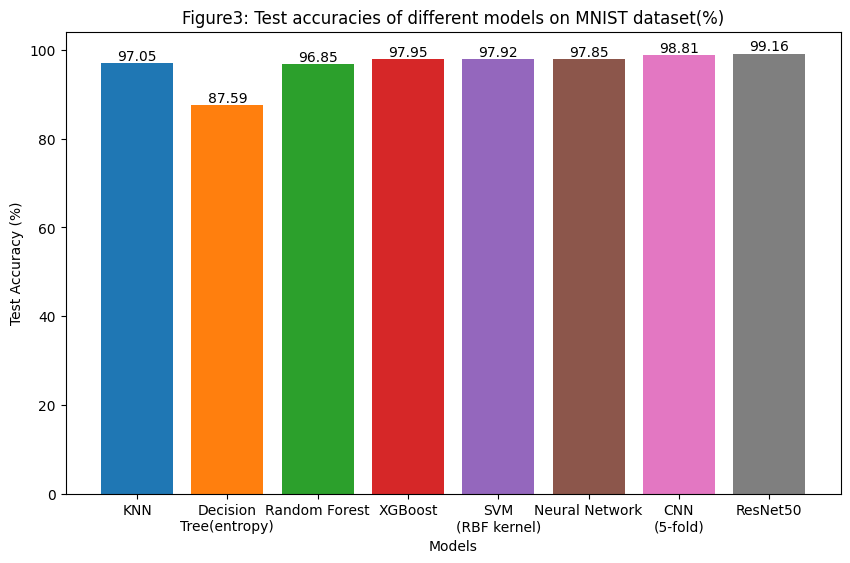

time: 736 ms (started: 2025-01-28 03:05:12 +00:00)


In [ ]:
# collation of test accuracies
models = ['KNN', 'Decision\nTree(entropy)', 'Random Forest', 'XGBoost', 'SVM\n(RBF kernel)', 'Neural Network', 'CNN\n(5-fold)', 'ResNet50']
test_accuracies = [knn_accuracy*100, dt_accuracy*100, round(accuracy_rf*100, 2), accuracy_xgb*100, svm_rbf*100, nn_accuracy, cnn_mean_accuracy, resnet_accuracy]

# plot a bar graph of the test accuracies of different models
plt.figure(figsize=(10, 6))
bars=plt.bar(models, test_accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])
plt.xlabel('Models')
plt.ylabel('Test Accuracy (%)')
plt.title('Figure3: Test accuracies of different models on MNIST dataset(%)')

# Add values on top of the bars
for bar, value in zip(bars, test_accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f'{value:.2f}' if isinstance(value, (int, float)) else value,  # Format numerical values to 2 decimal places
             ha='center', va='bottom')

plt.show()


# Discussion
Among the models, ResNet50 achieved the highest test accuracy (99.16%) as expected due to its pretrained nature and the strength of CNN. A self-defined CNN model lagged slightly behind. However, they are also the models that takes the longest time to train, particularly ResNet50. Without utilising GPUs, it is not practical to implement ResNet50, even for a smaller dataset like MNIST. Surprisingly, a self-defined neural network only achieved a test accuracy barely on a par with the traditional algorithms of SVM and XGBoost, but the latter two also required high computational resources. It is also interesting that KNN, as a very simple and easy to implement algorithm, achieved an accuracy (97.05%) very close to the more complicated algorithms. Therefore, it seems that a few traditional machine learning algorithms worked relatively well on MNIST, probably because it is a smaller dataset. CNNs and more complicated neural networks may take longer time to train, but they are more scalable and therefore more suitable for large dataset. In addition, the performances of these algorithms varied across digits, with many of them were plagued by more complex images such as 9, 7 and 4, which indicated the impact of the feature complexity. There are limitations on our conclusion though. Since not all the hyperparameters were tuned in the experiment, and k-fold cross validation was not always implemented, some of the test accuracies reported here could vary when the experiment is repeated.


# Reference
Gopalakrishnan, R.(2022). A Simple Neural Network on MNIST dataset using Pytorch. Available at: https://medium.com/@ramamurthi96/a-simple-neural-network-model-for-mnist-using-pytorch-4b8b148ecbdc (Accessed: 04 Jan 2025)

Lin, N. (2017). MNIST Dataset: Digit Recognizer. Available at: https://www.kaggle.com/code/ngbolin/mnist-dataset-digit-recognizer/notebook (Accessed: 02 Jan 2025)

NAIDU, B.(2021). PCA and t-SNE on Digit MNIST. Available at: https://www.kaggle.com/code/bhaveshnaidu/pca-and-t-sne-on-digit-mnist/notebook (Accessed: 24 Dec 2025)

Rana, M. (2023). Comparison of the Error Rates of MNIST Datasets Using Different Type of Machine Learning Model. North American Academic Research, 6(5), DOI:10.5281/zenodo.8010602